In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [15]:
stock_names = np.array(['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DD','XOM','GE','GS','HD',\
                       'IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','RTX','VZ','V',\
                        'WMT'])
stocks = np.zeros((29,250,1),dtype=float)
for i in range(stock_names.shape[0]):
    temp_stock = pd.DataFrame(yf.download(stock_names[i],start='2018-01-01',end='2018-12-31'))
    stocks[i] = (np.array(temp_stock['Close'])).reshape(250,1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
(200, 1)
(50, 1)
122.83999633789062
147.83999633789062


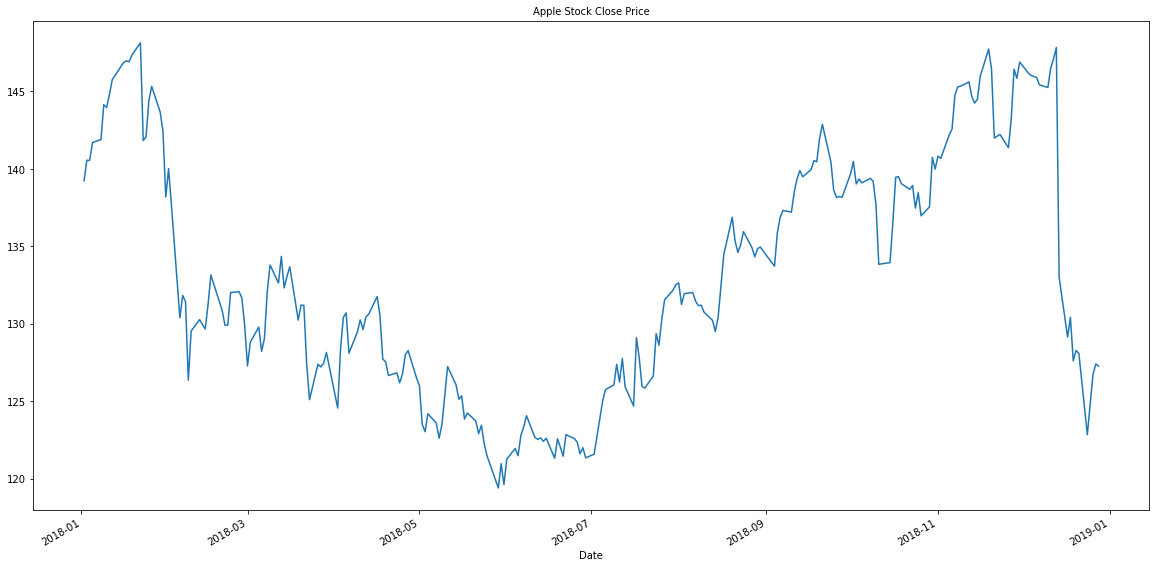

In [16]:
apple = yf.download('JNJ',start='2018-01-01',end='2018-12-31')

apple = apple.sort_values('Date')
apple.head()
plt.title('Apple Stock Close Price',fontsize=10)
apple['Close'].plot()
close_price = np.array(apple['Close'])
train_apple = close_price[:len(close_price)-50]
test_apple = close_price[len(close_price)-50:]
min_apple = np.min(test_apple)
max_apple = np.max(test_apple)
scale = MinMaxScaler()
train_apple = train_apple.reshape(-1,1)
test_apple = test_apple.reshape(-1,1)
close_price = close_price.reshape(-1,1)
print(train_apple.shape)
print(test_apple.shape)
print(min_apple)
print(max_apple)


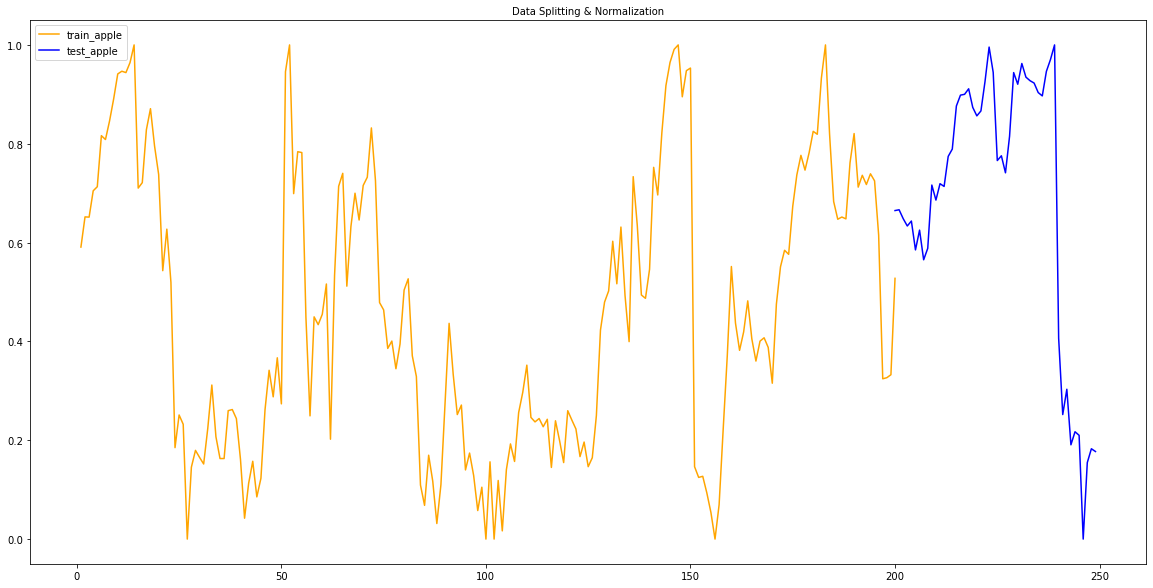

In [17]:
#Data Normalization
s_window = 50
nclose_price = np.zeros((len(close_price),1))
for i in range(0,len(close_price),s_window):
  scale.fit(close_price[i:i + s_window,:])
  nclose_price[i:i+s_window,:] = scale.transform(close_price[i:i+s_window,:])
# for i in range(0,263,263):
#   scale.fit(test_apple[i:i + s_window,:])
#   test_apple[i:i+s_window,:] = scale.transform(test_apple[i:i+s_window,:])
train_apple = nclose_price[:len(close_price)-50]
test_apple = nclose_price[len(close_price)-50:]
date1 = np.arange(len(close_price)-50)+1
date2 = np.arange(len(close_price)-51,len(close_price)-1)+1
plt.title('Data Splitting & Normalization',fontsize=10)
plt.plot(date1,train_apple,label='train_apple',color = 'orange')
plt.plot(date2,test_apple,label='test_apple',color = 'blue')
plt.legend(loc="upper left")

200


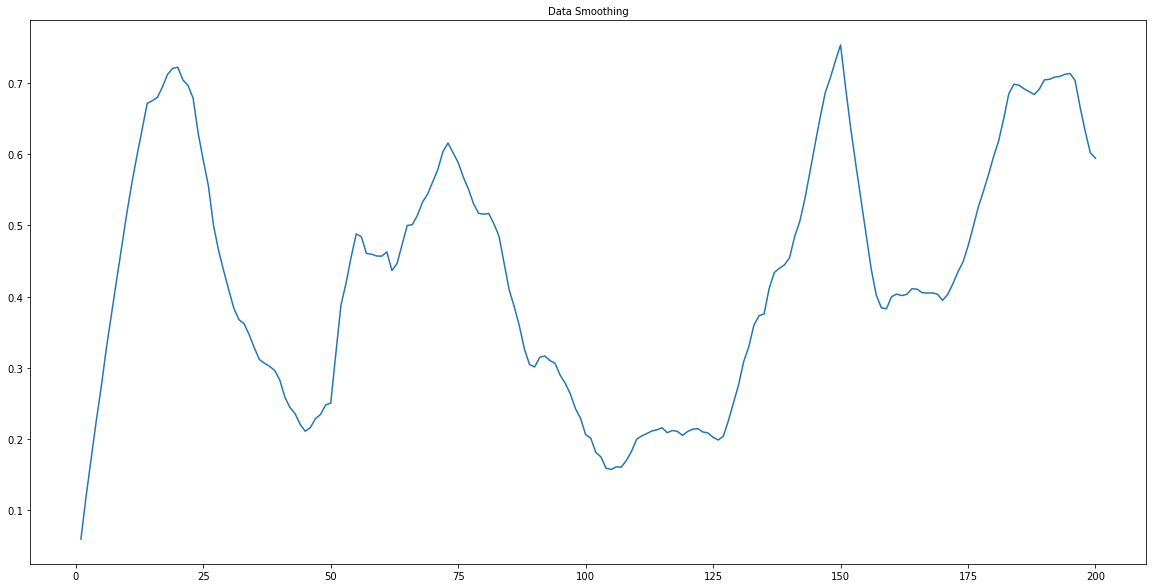

In [18]:
#Data Smoothing
EMA = 0.0
lamda = 0.1
for i in range(len(close_price)-50):
  EMA = lamda*train_apple[i] + (1-lamda)*EMA
  train_apple[i] = EMA
plt.plot(date1,train_apple,label='Apple')
plt.title('Data Smoothing',fontsize=10)
all_apple = np.concatenate([train_apple,test_apple],axis=0)
print(len(train_apple))

In [19]:
#Data Generation
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [20]:
#Data Generation
x_train_data,y_train_data=[],[]
for i in range(60,len(train_apple)):
    x_train_data.append(train_apple[i-60:i,0])
    y_train_data.append(train_apple[i,0])
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
print(x_train_data.shape,y_train_data.shape)

(140, 60, 1) (140,)


In [21]:
#LSTM Model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=all_apple[len(all_apple)-len(test_apple)-60:]
inputs_data=inputs_data.reshape(-1,1)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=1,verbose=2)

Epoch 1/10
140/140 - 4s - loss: 0.0160 - 4s/epoch - 29ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0072 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0049 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0045 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 12ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0022 - 2s/epoch - 12ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 12ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 8.8811e-04 - 2s/epoch - 13ms/step


In [22]:
#Predict
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)

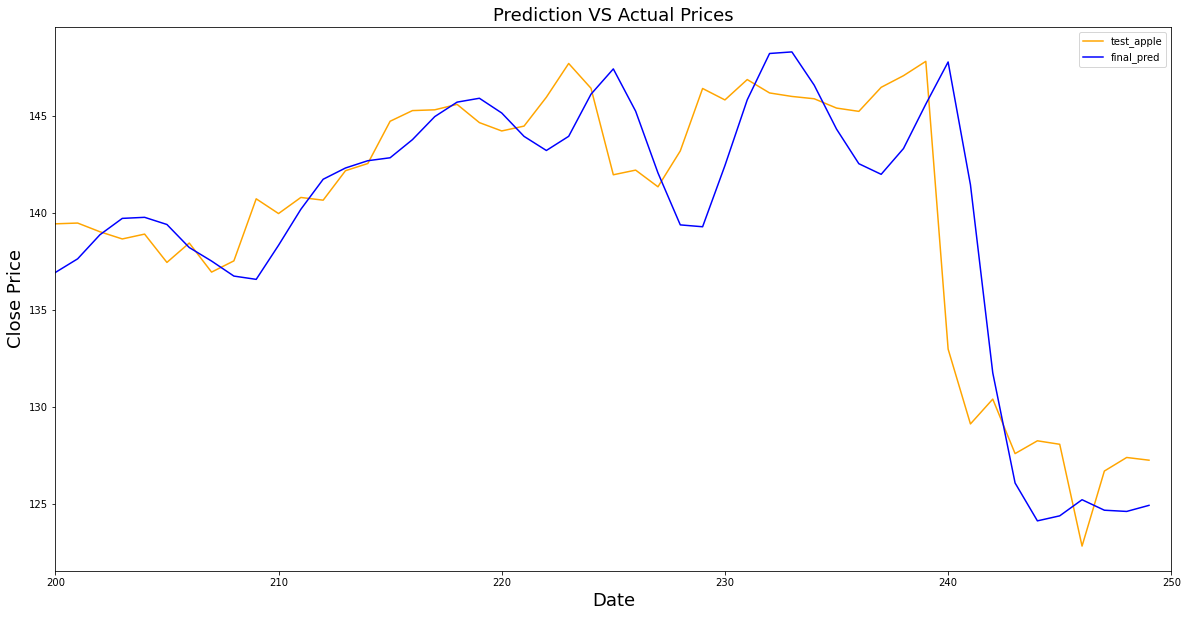

In [23]:
# date2 = np.arange(2212,2262)+1
test_apple_scale = test_apple*(max_apple-min_apple) + min_apple
final_pred = predicted_closing_price*(max_apple-min_apple) + min_apple
plt.plot(date2,test_apple_scale,label='test_apple',color = 'orange')
plt.plot(date2,final_pred,label='final_pred',color = 'blue')
plt.title('Prediction VS Actual Prices',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.xlim(len(close_price)-50,len(close_price))
plt.legend(loc="upper right")
plt.show()

In [24]:
stock_names = np.array(['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DD','XOM','GE','GS','HD',\
                       'IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','RTX','VZ','V',\
                        'WMT'])

In [25]:
# Name 
DIA = yf.download('DIA',start='2018-01-01',end='2018-12-31')
dia_price = (np.array(DIA['Close'])).reshape(250,1)
# SMA_len = 25 * np.ones(29)
SMA_len = np.array([35,200,200,36,23,5,39,9,16,100,8,14,6,40,40,26,5,6,5,13,200,5,6,23,44,50,7,200,100])
print(SMA_len[1])
stock_SMA = np.zeros((29,250,1),dtype=float) # a

for i in range(29):
    stock = yf.download(stock_names[i],start='2018-01-01',end='2018-12-31')
    stock["SMA"]= stock.iloc[:,4].rolling(window = int(SMA_len[i])).mean()
    stock_SMA[i] = (np.array(stock['SMA'])).reshape(250,1)

[*********************100%***********************]  1 of 1 completed
200
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%****

Epoch 1/10
140/140 - 4s - loss: 0.0126 - 4s/epoch - 28ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0077 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0063 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0042 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0033 - 2s/epoch - 15ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 15ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 14ms/step


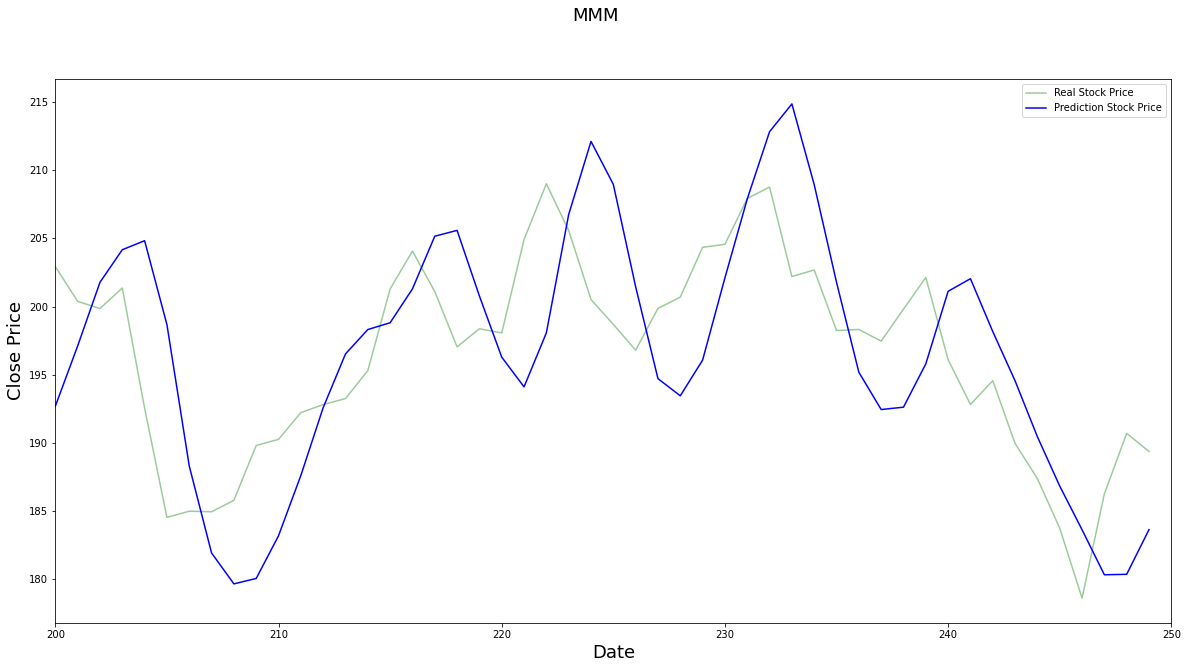

Buy at day:  9
Sell at day:  15
Total invest days: 1
Profit made by our model: [5.11868782] %
Profit made by DIA model: [4.81041016] %
MMM  is chosen
Epoch 1/10
140/140 - 4s - loss: 0.0283 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0077 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0056 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0045 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0034 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0040 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0036 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0027 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 13ms/step


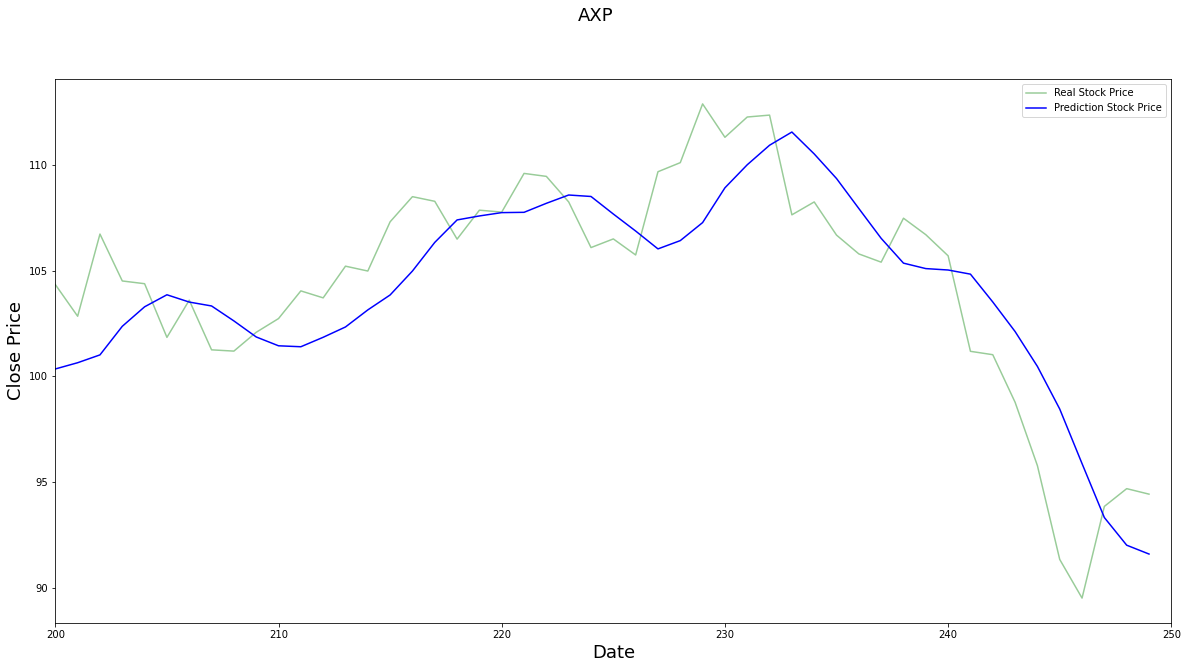

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0193 - 4s/epoch - 30ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0074 - 2s/epoch - 15ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0053 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0041 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0032 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0020 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 15ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 15ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 14ms/step


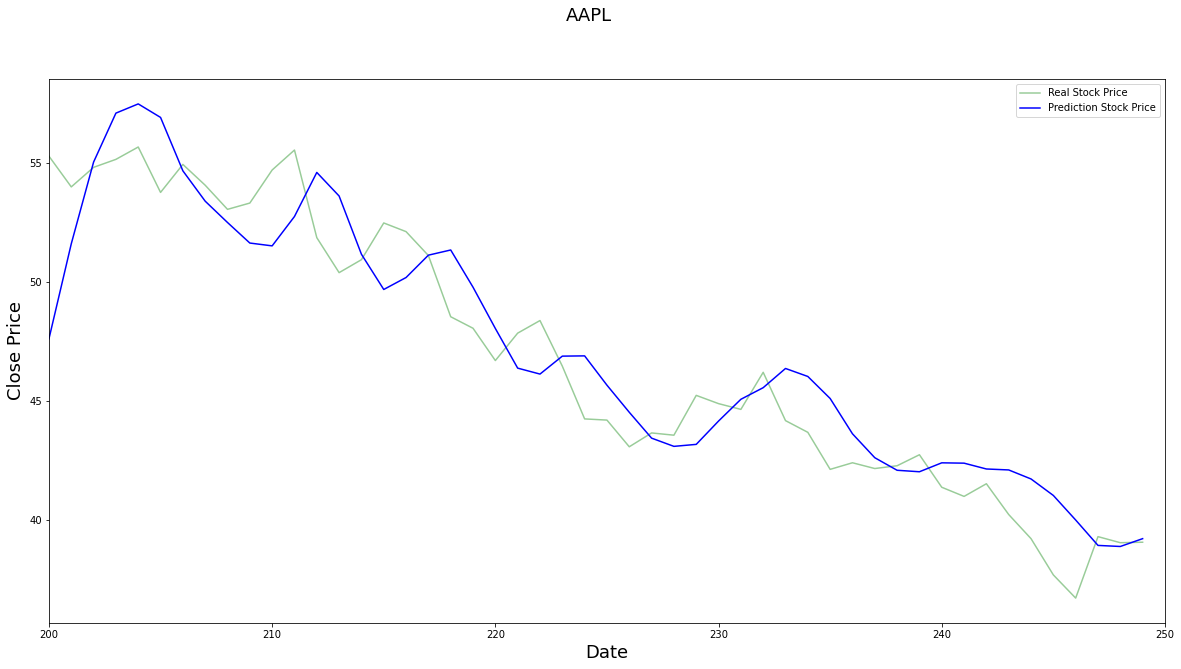

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0224 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0055 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0033 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0032 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step


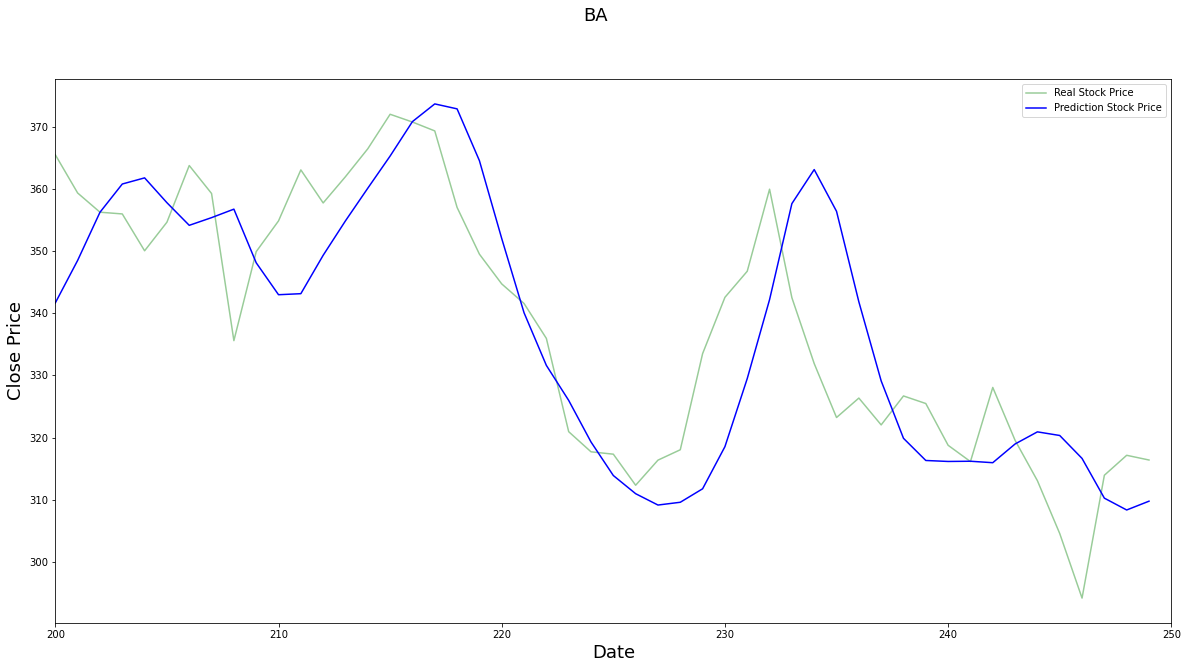

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0274 - 4s/epoch - 27ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0071 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0052 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0036 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0025 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0022 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0012 - 2s/epoch - 14ms/step


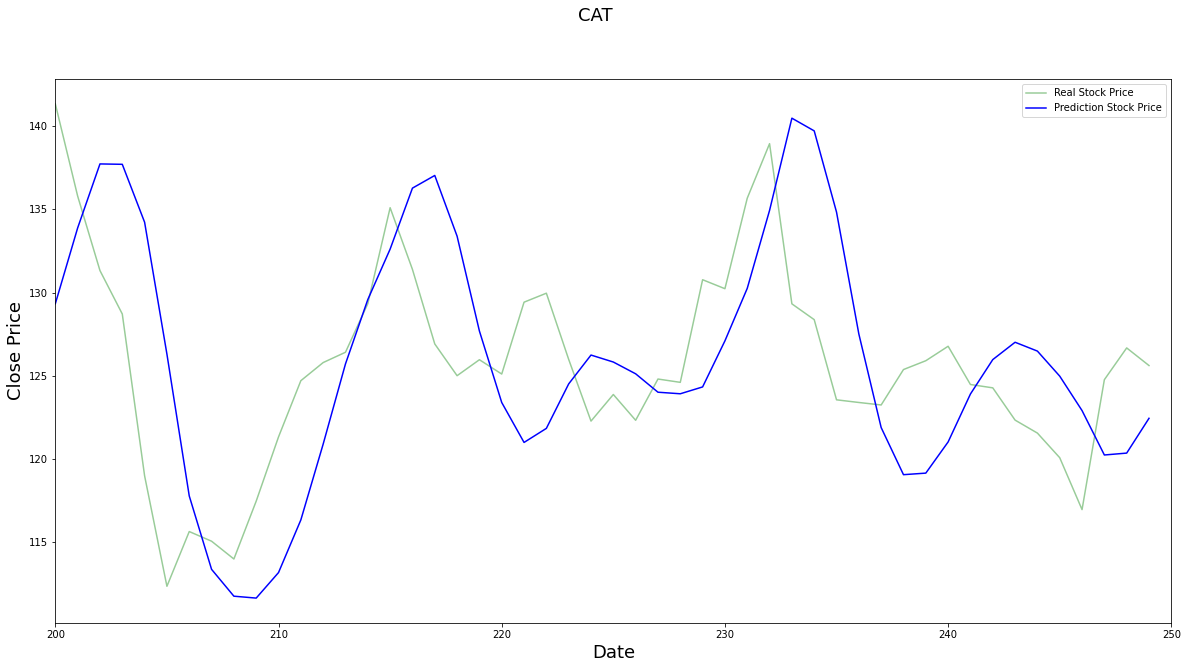

Buy at day:  9
Buy at day:  10
Sell at day:  14
Total invest days: 2
Profit made by our model: [9.26252055] %
Profit made by DIA model: [3.20932722] %
CAT  is chosen
Epoch 1/10
140/140 - 4s - loss: 0.0213 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0078 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0060 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0048 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step


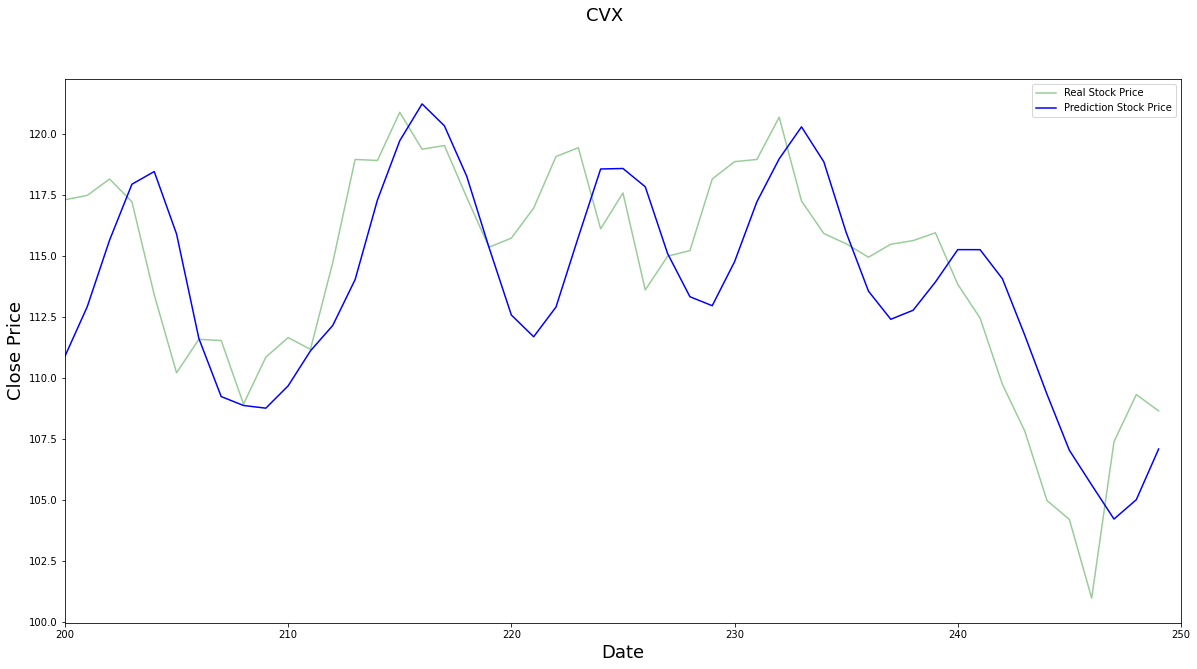

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0225 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0070 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0053 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0044 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0026 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step


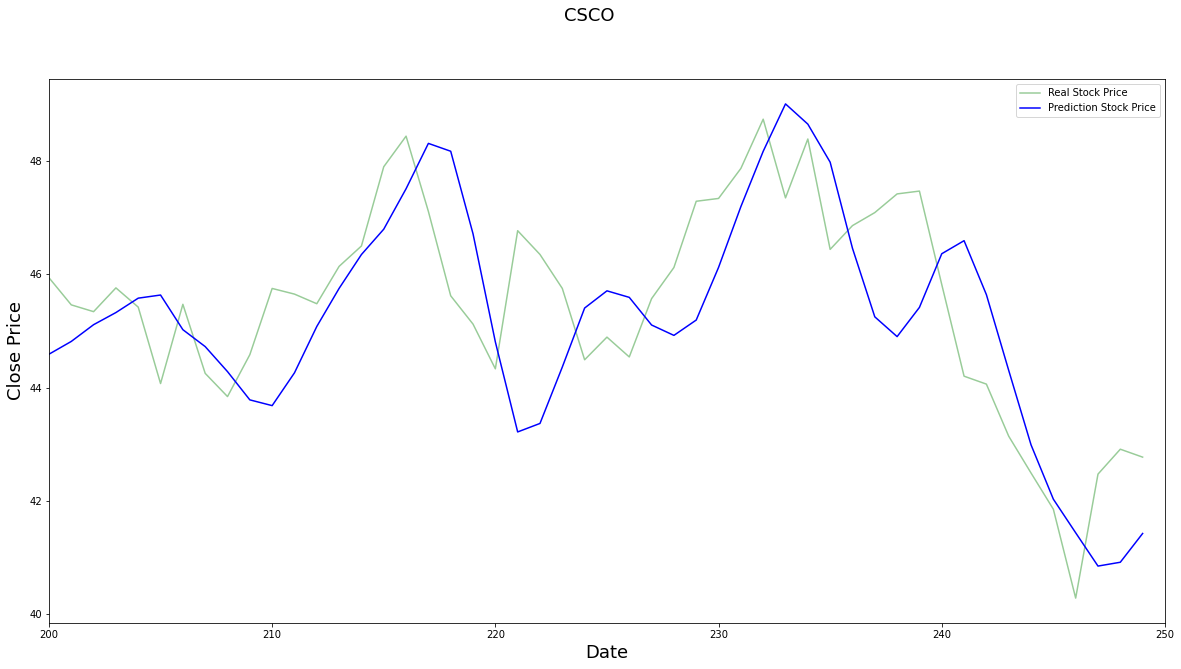

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0216 - 4s/epoch - 25ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0067 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0044 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0041 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0037 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0026 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0020 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step


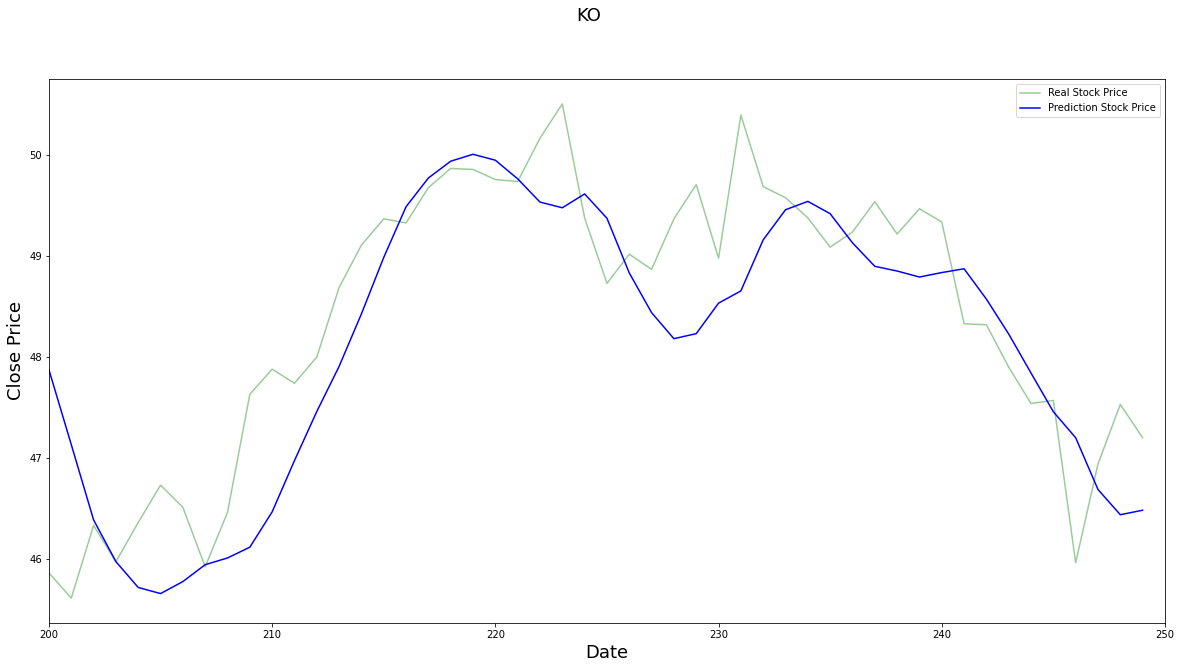

Buy at day:  6
Epoch 1/10
140/140 - 4s - loss: 0.0186 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0071 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0044 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0031 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0020 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 8.7001e-04 - 2s/epoch - 13ms/step


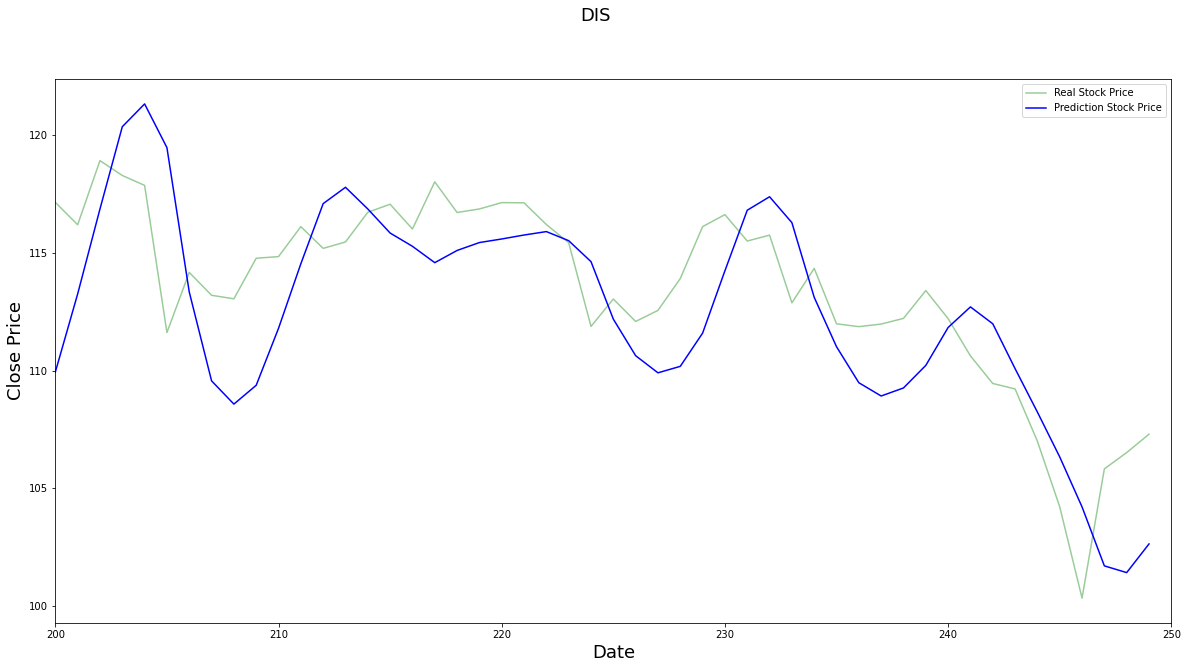

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0187 - 4s/epoch - 25ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0117 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0078 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0065 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0042 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0031 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0012 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step


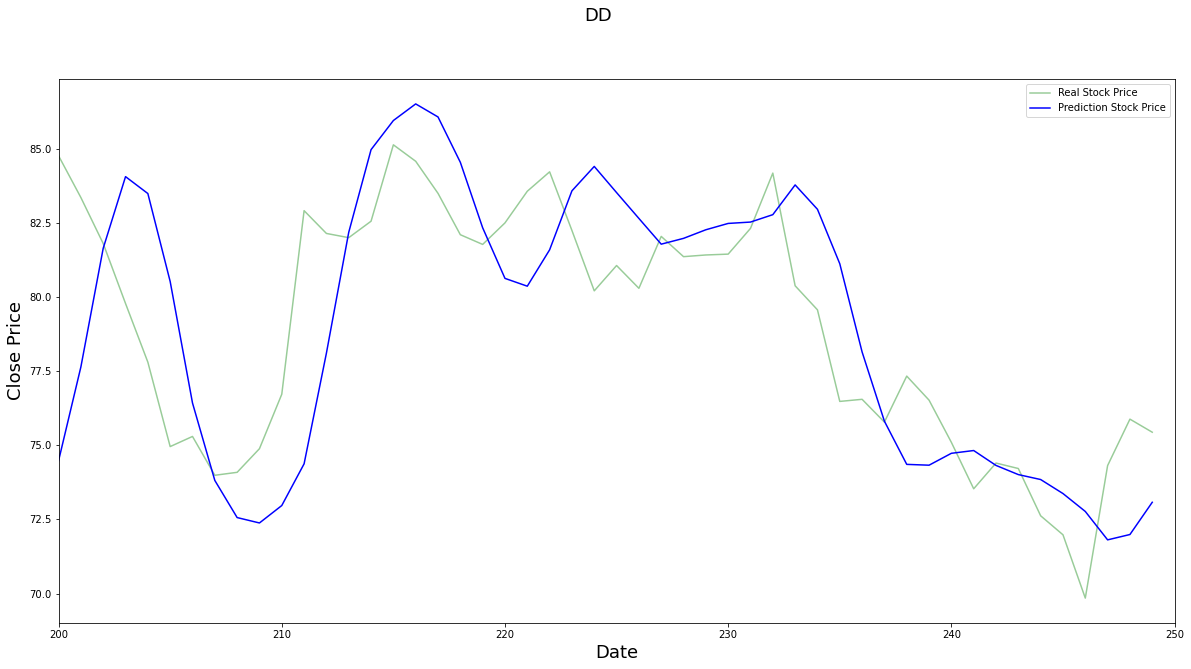

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0164 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0052 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0049 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0038 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0026 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0012 - 2s/epoch - 13ms/step


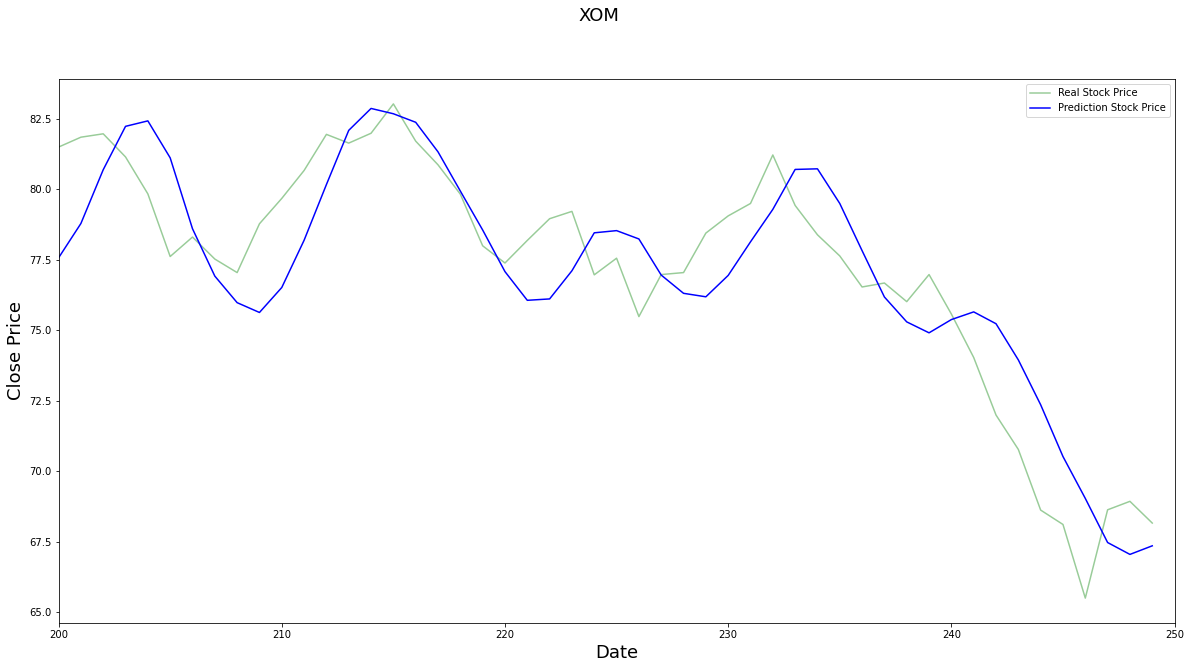

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0143 - 4s/epoch - 25ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0067 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0047 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0038 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0028 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0025 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 14ms/step


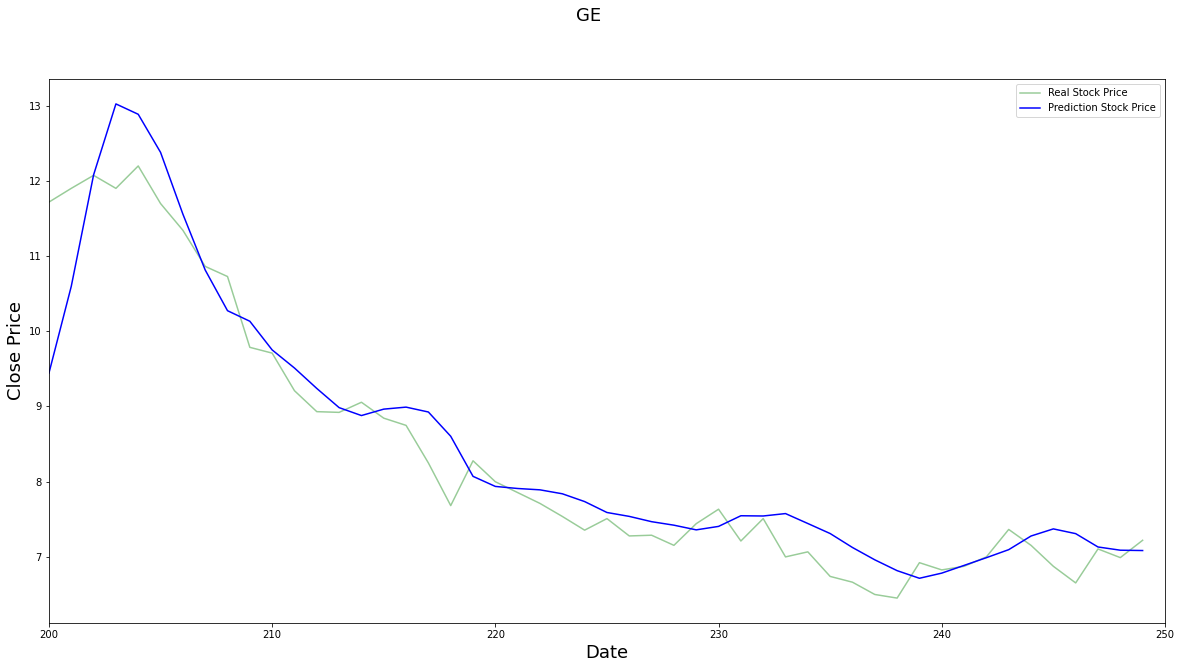

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0184 - 4s/epoch - 27ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0078 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0044 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0010 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 9.8471e-04 - 2s/epoch - 13ms/step


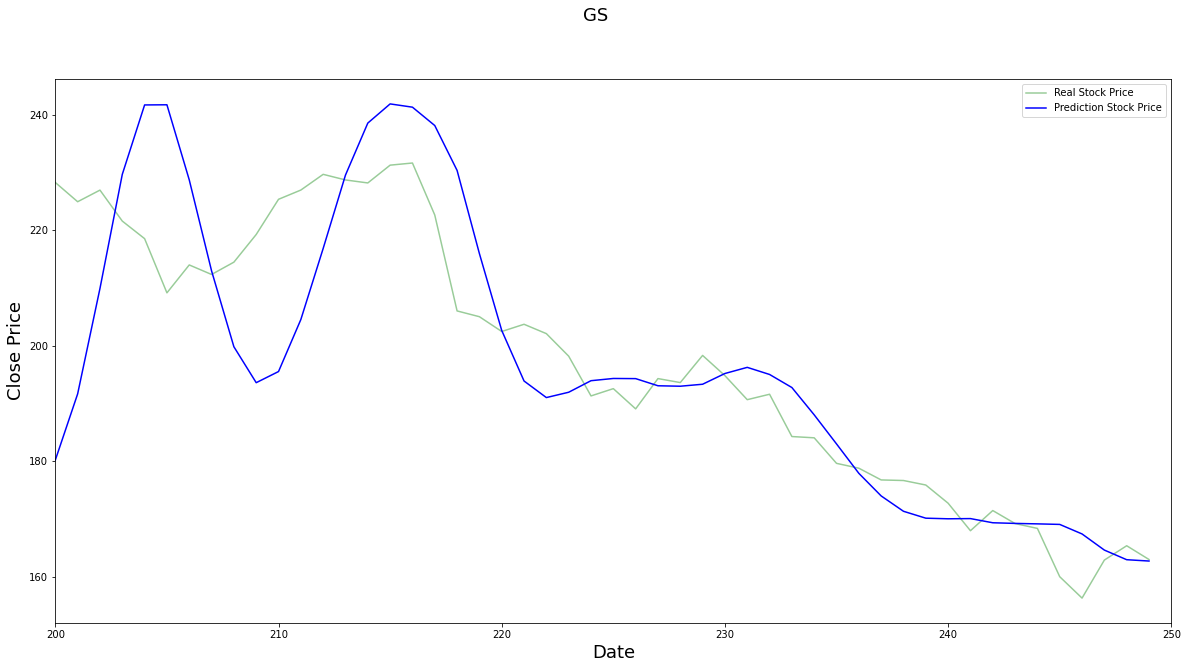

We will not choose this stock.
Epoch 1/10
140/140 - 3s - loss: 0.0197 - 3s/epoch - 25ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0095 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0027 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step


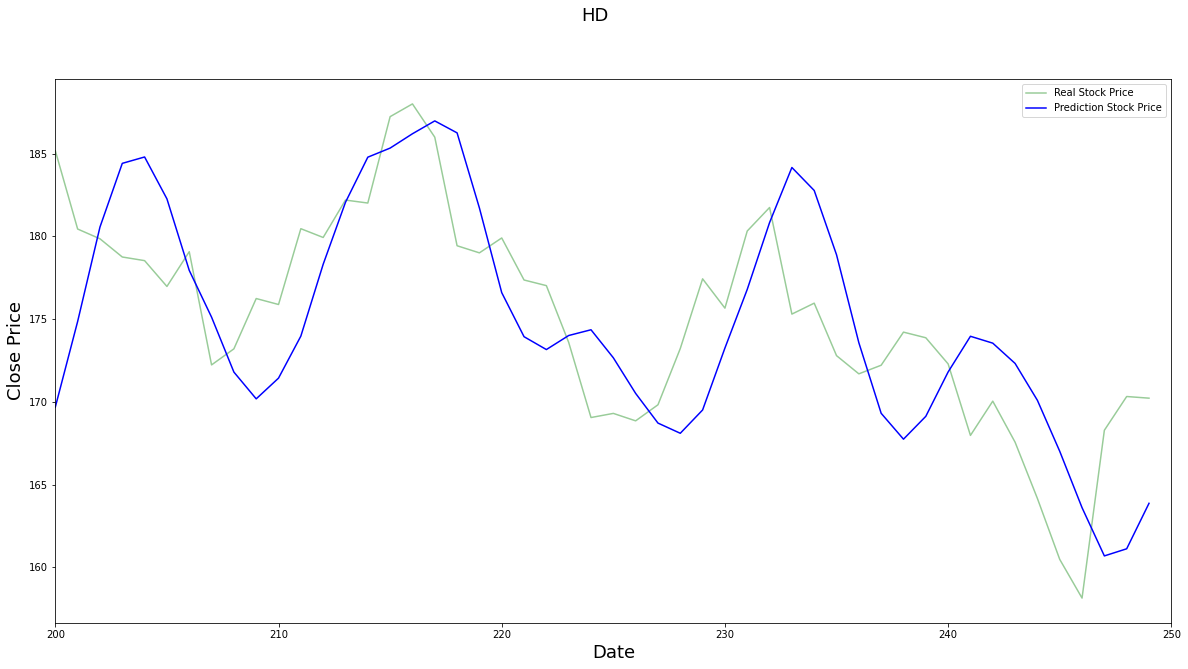

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0243 - 4s/epoch - 27ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0076 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0037 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0031 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0012 - 2s/epoch - 14ms/step


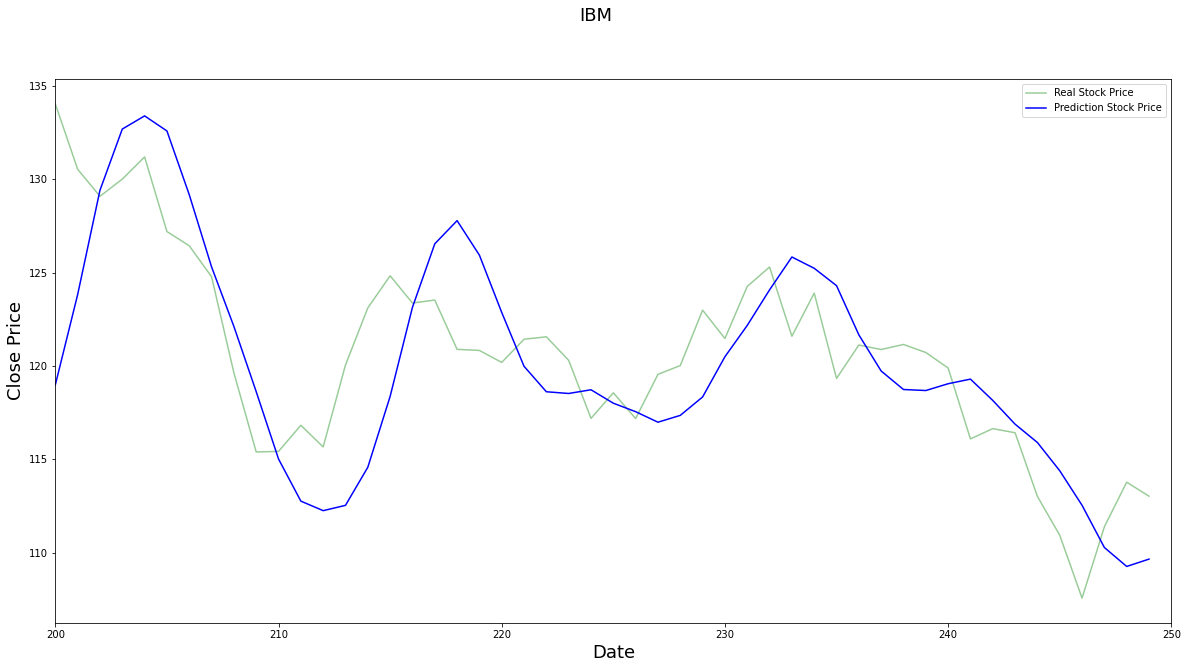

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0199 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0065 - 2s/epoch - 15ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0046 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0042 - 2s/epoch - 15ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0039 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0031 - 2s/epoch - 15ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0040 - 2s/epoch - 15ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0022 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 15ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 14ms/step


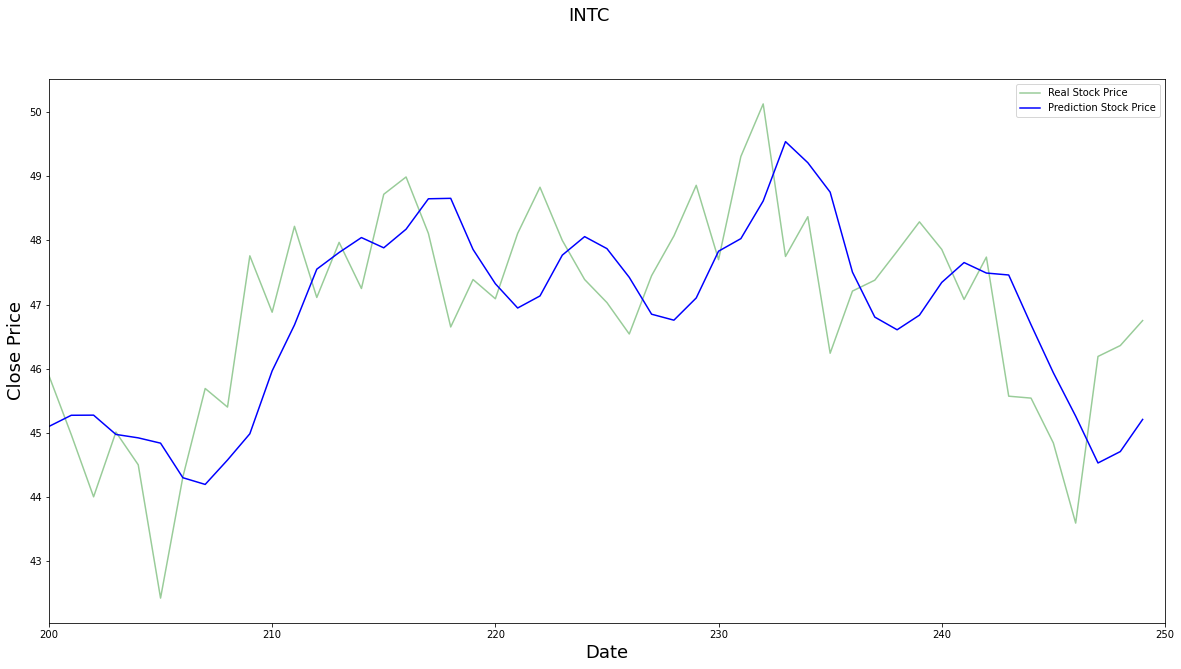

Buy at day:  8
Sell at day:  18
Total invest days: 1
Epoch 1/10
140/140 - 4s - loss: 0.0235 - 4s/epoch - 28ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0069 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0056 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0043 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0033 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0026 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step


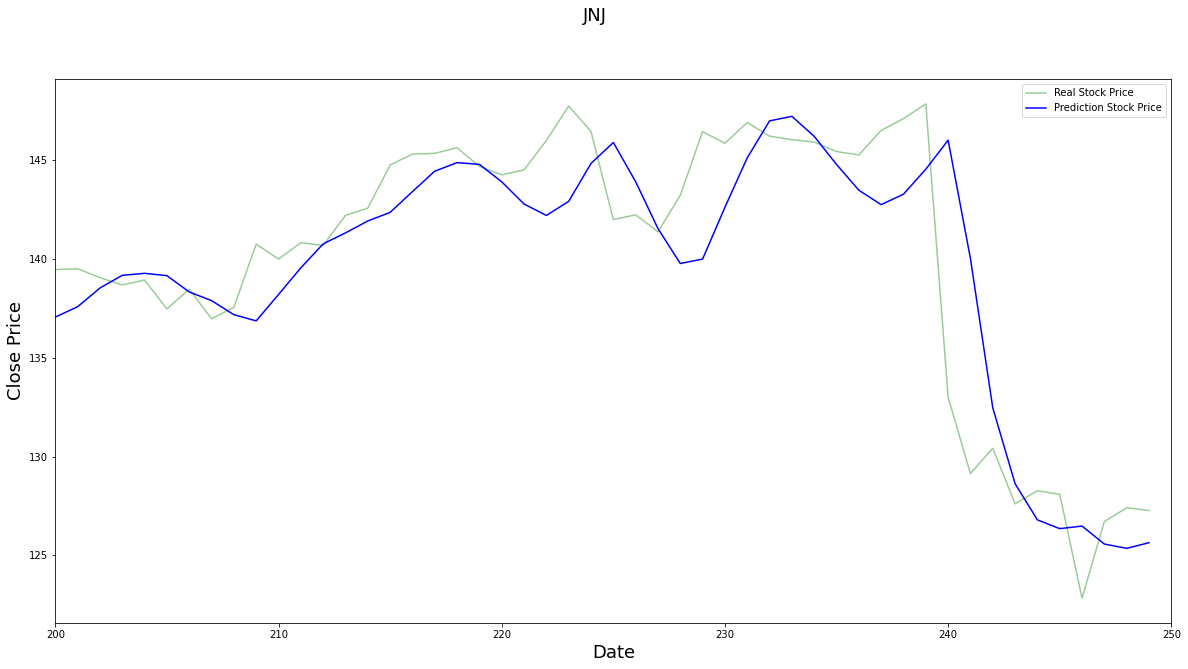

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0221 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0081 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0052 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0051 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0028 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0029 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step


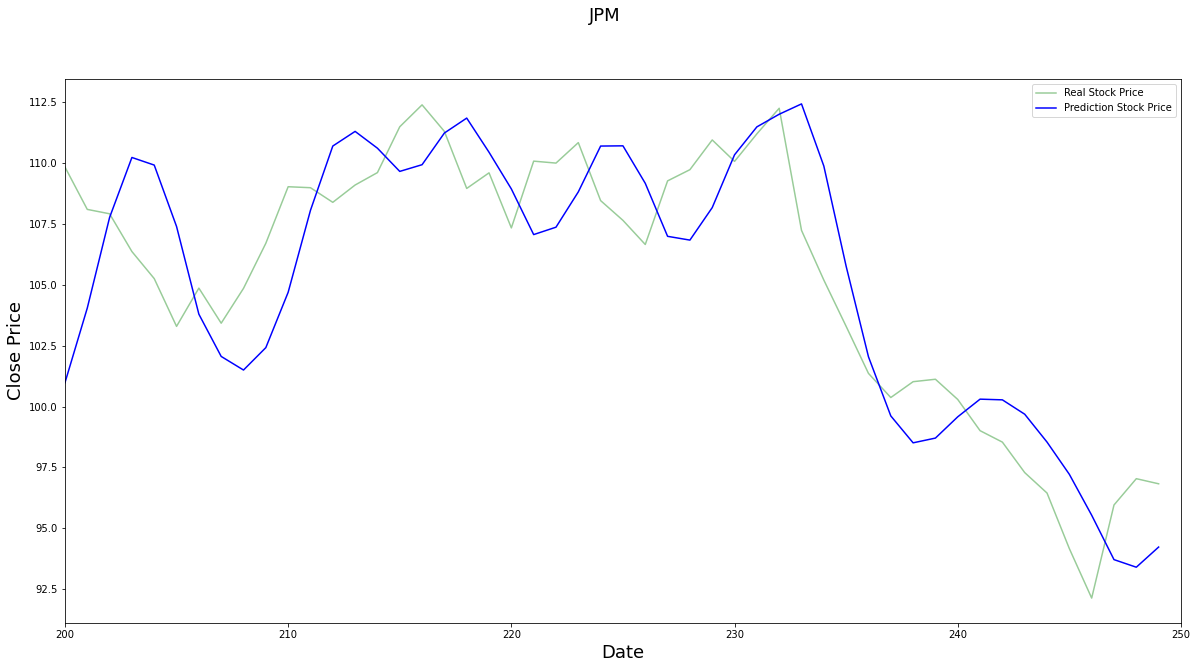

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0146 - 4s/epoch - 27ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0072 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0050 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0034 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 14ms/step


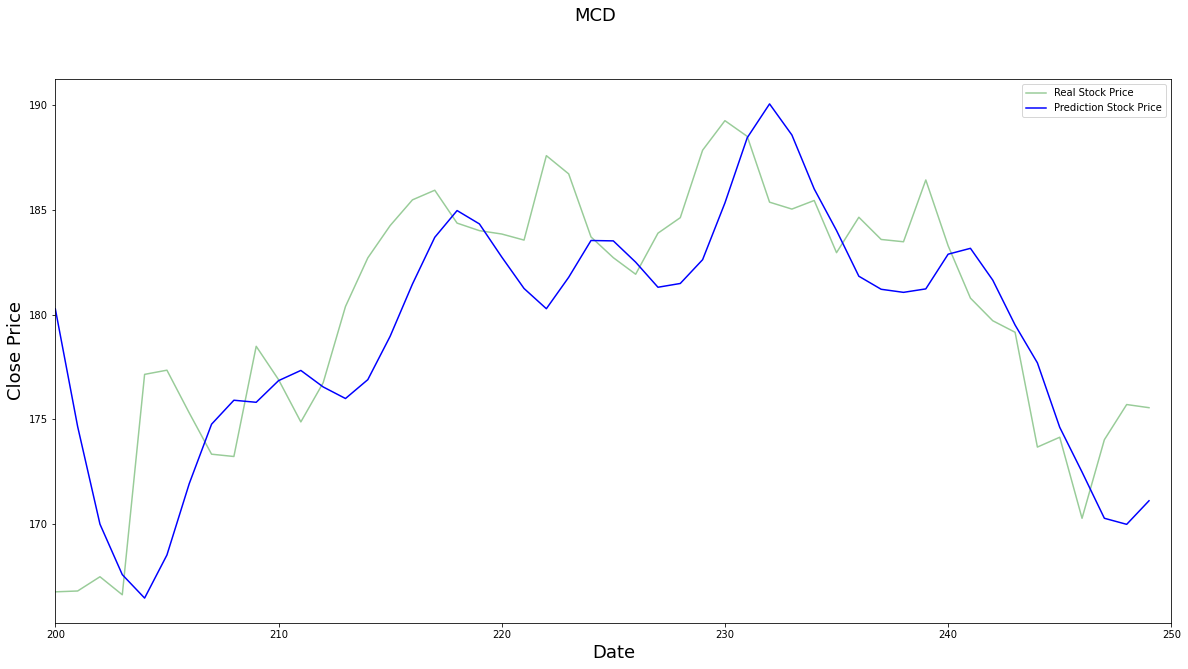

Buy at day:  5
Sell at day:  18
Total invest days: 1
Profit made by our model: [4.96190169] %
Profit made by DIA model: [3.34565035] %
MCD  is chosen
Epoch 1/10
140/140 - 4s - loss: 0.0197 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0079 - 2s/epoch - 15ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0059 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0039 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0037 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0025 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 15ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 15ms/step


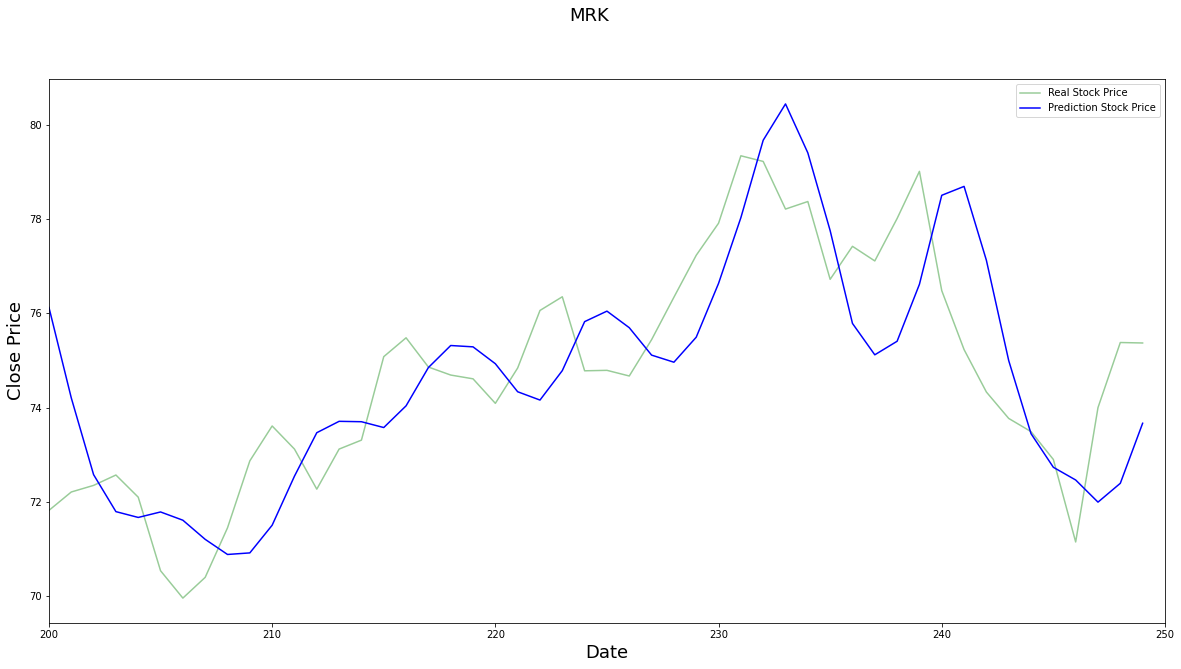

Buy at day:  9
Buy at day:  10
Sell at day:  32
Total invest days: 2
Profit made by our model: [9.96075149] %
Profit made by DIA model: [3.62706332] %
MRK  is chosen
Epoch 1/10
140/140 - 4s - loss: 0.0263 - 4s/epoch - 28ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0085 - 2s/epoch - 15ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0050 - 2s/epoch - 15ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0039 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0026 - 2s/epoch - 15ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0017 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 15ms/step


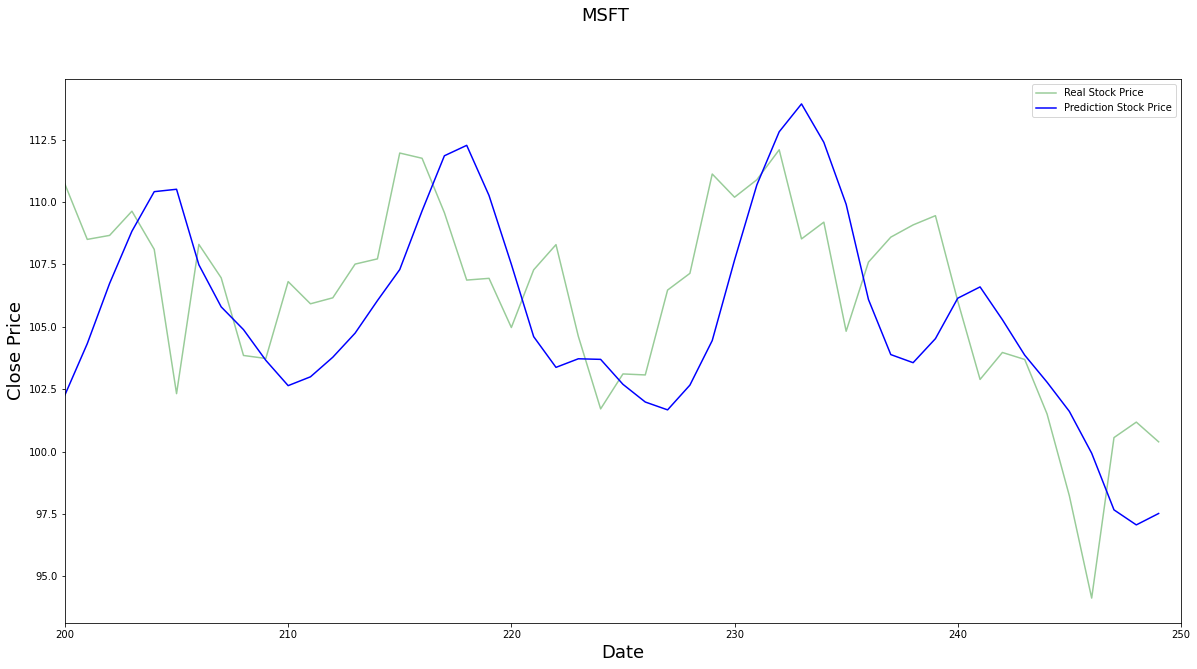

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0187 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0066 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0055 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0046 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0038 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0012 - 2s/epoch - 14ms/step


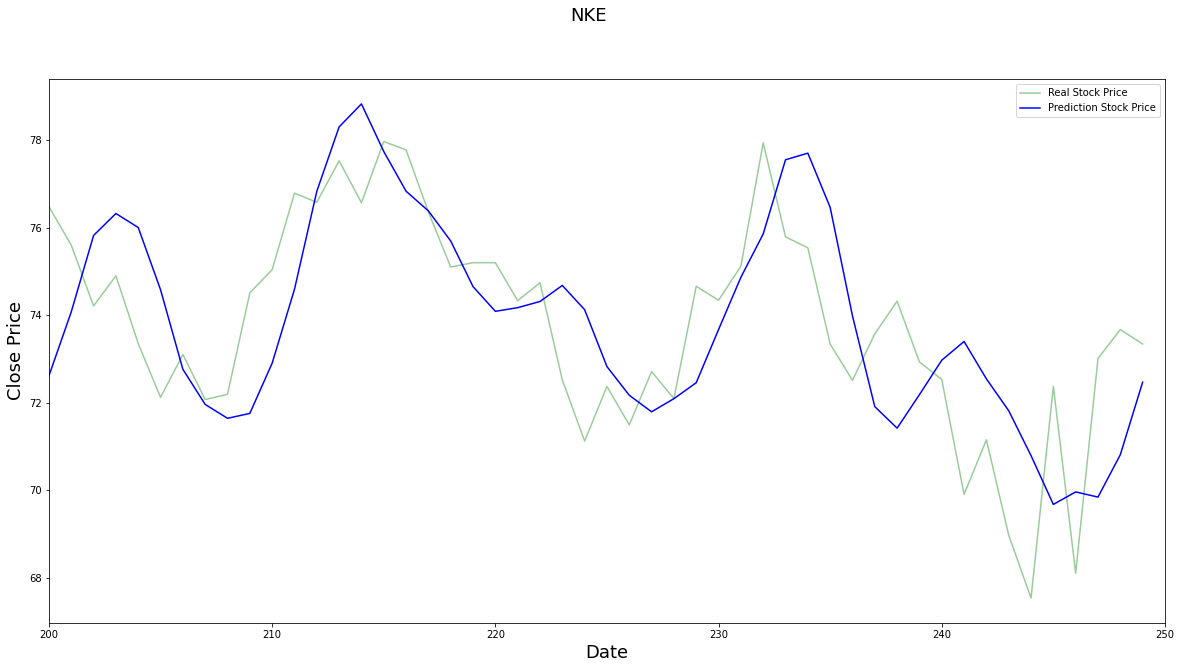

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0215 - 4s/epoch - 28ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0071 - 2s/epoch - 13ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0059 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 13ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0010 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0010 - 2s/epoch - 13ms/step


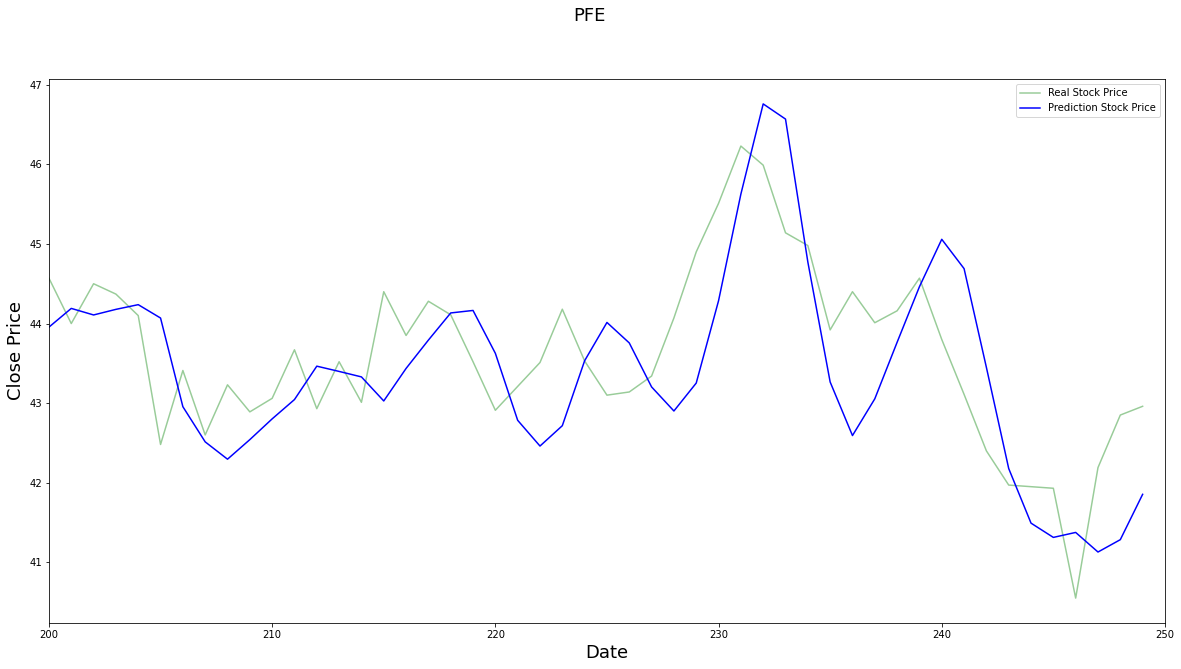

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0158 - 4s/epoch - 27ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0066 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0038 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0036 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0022 - 2s/epoch - 15ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0020 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 14ms/step


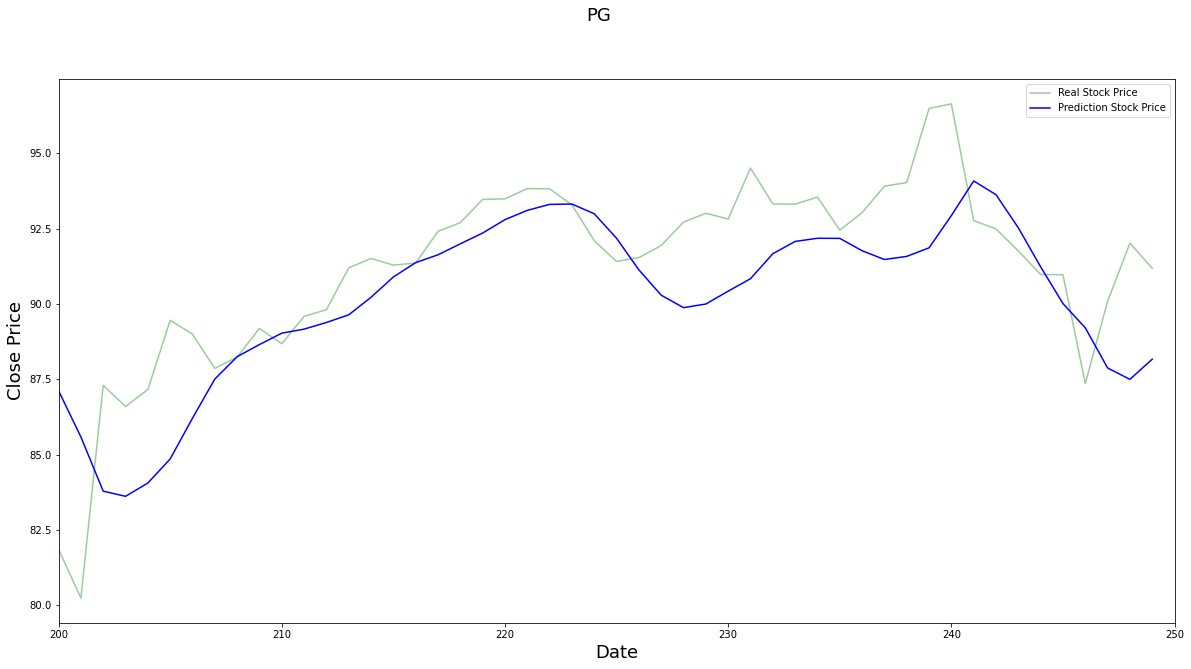

Buy at day:  4
Sell at day:  19
Total invest days: 1
Profit made by our model: [7.04387827] %
Profit made by DIA model: [0.46633258] %
PG  is chosen
Epoch 1/10
140/140 - 4s - loss: 0.0185 - 4s/epoch - 28ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0070 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0047 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0044 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0030 - 2s/epoch - 13ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0029 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0029 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0023 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0020 - 2s/epoch - 14ms/step


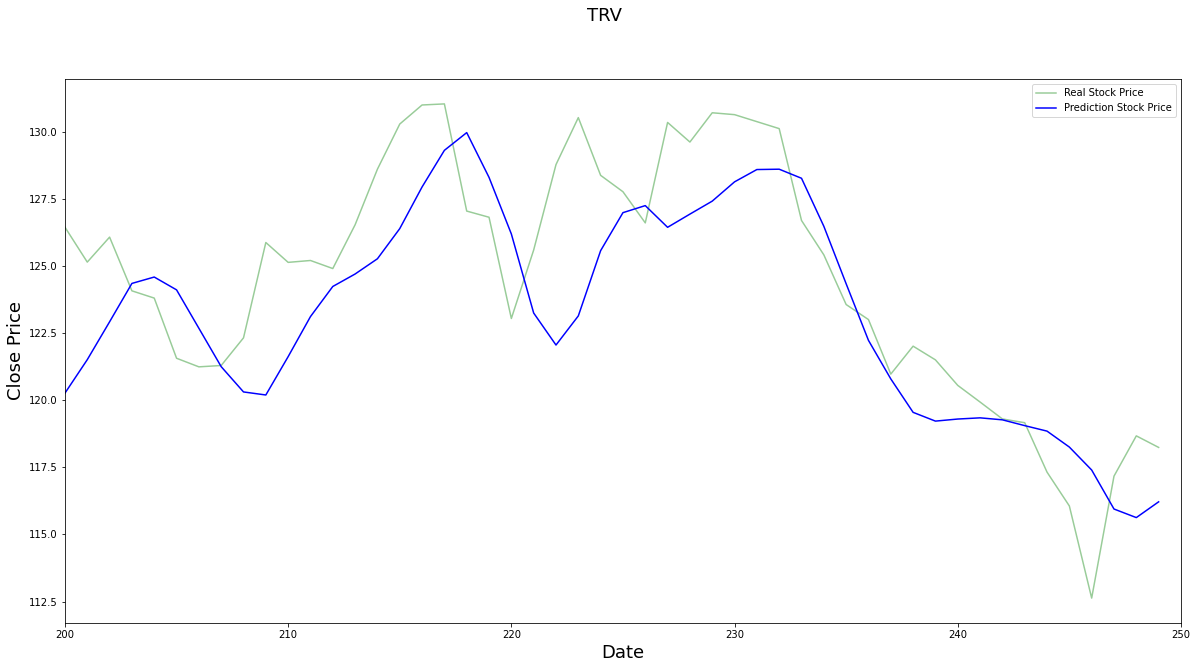

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0188 - 4s/epoch - 26ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0065 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0038 - 2s/epoch - 15ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0031 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0025 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0025 - 2s/epoch - 13ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 13ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0011 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 13ms/step


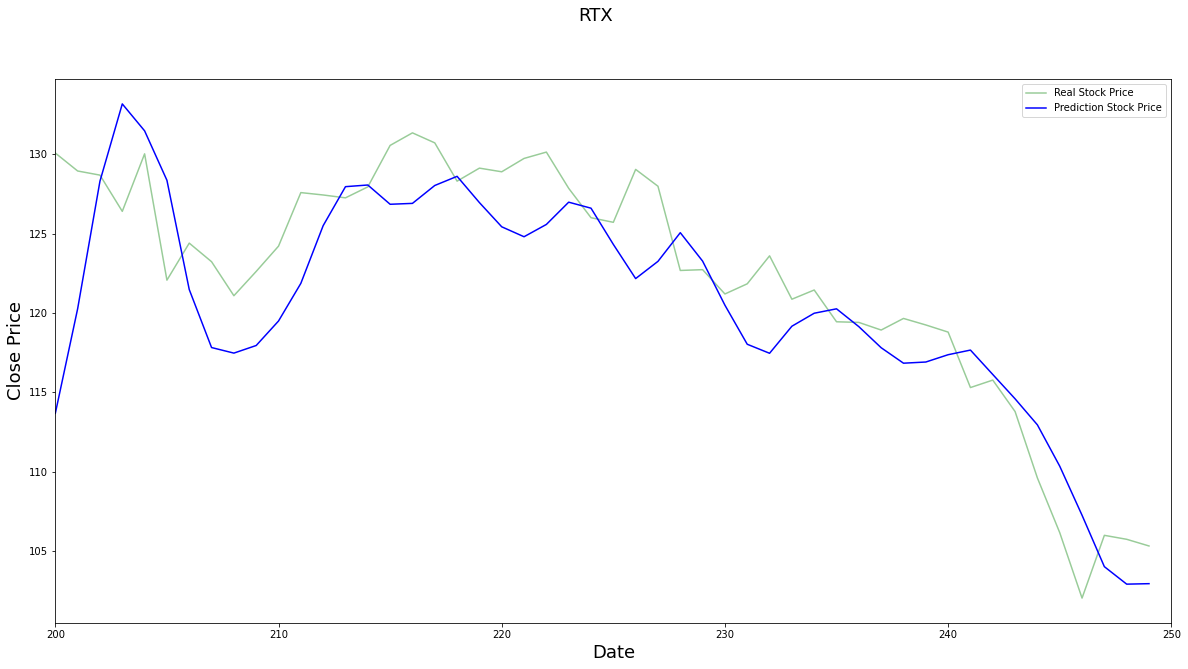

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0146 - 4s/epoch - 27ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0072 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0047 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0044 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0038 - 2s/epoch - 14ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0027 - 2s/epoch - 15ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0018 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0013 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0014 - 2s/epoch - 16ms/step


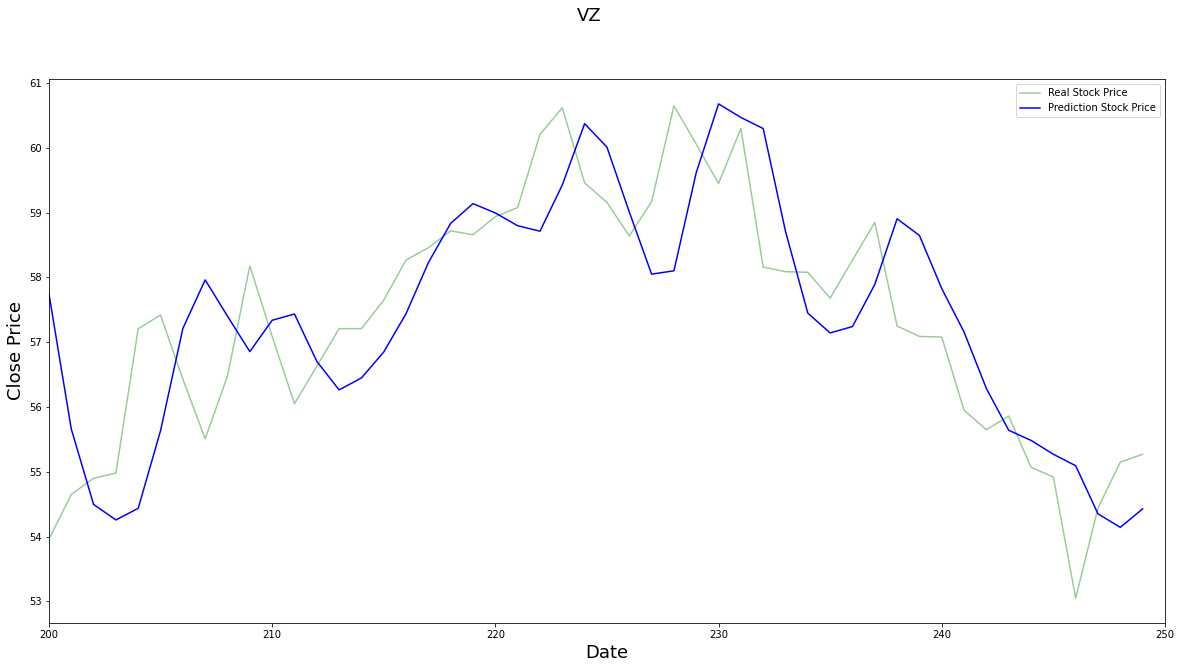

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0248 - 4s/epoch - 32ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0071 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0047 - 2s/epoch - 13ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0035 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0028 - 2s/epoch - 15ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0024 - 2s/epoch - 14ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0019 - 2s/epoch - 13ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0015 - 2s/epoch - 13ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0012 - 2s/epoch - 13ms/step


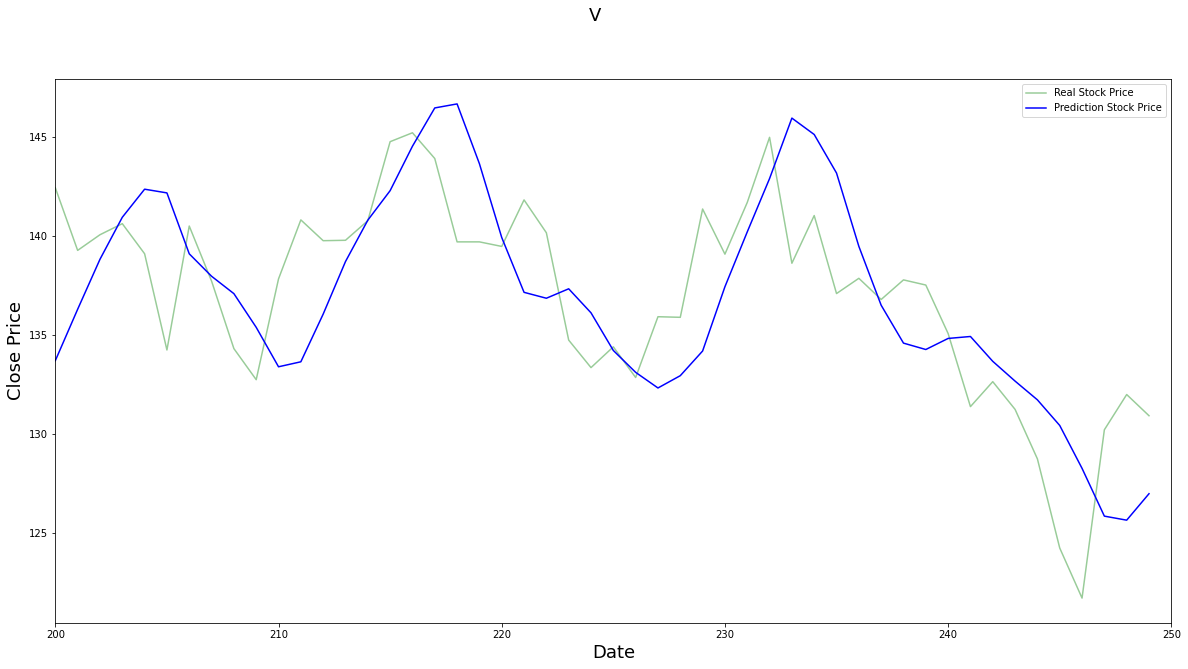

We will not choose this stock.
Epoch 1/10
140/140 - 4s - loss: 0.0210 - 4s/epoch - 28ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0078 - 2s/epoch - 14ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0051 - 2s/epoch - 14ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0045 - 2s/epoch - 14ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0042 - 2s/epoch - 16ms/step
Epoch 6/10
140/140 - 2s - loss: 0.0037 - 2s/epoch - 15ms/step
Epoch 7/10
140/140 - 2s - loss: 0.0031 - 2s/epoch - 14ms/step
Epoch 8/10
140/140 - 2s - loss: 0.0022 - 2s/epoch - 14ms/step
Epoch 9/10
140/140 - 2s - loss: 0.0021 - 2s/epoch - 14ms/step
Epoch 10/10
140/140 - 2s - loss: 0.0016 - 2s/epoch - 14ms/step


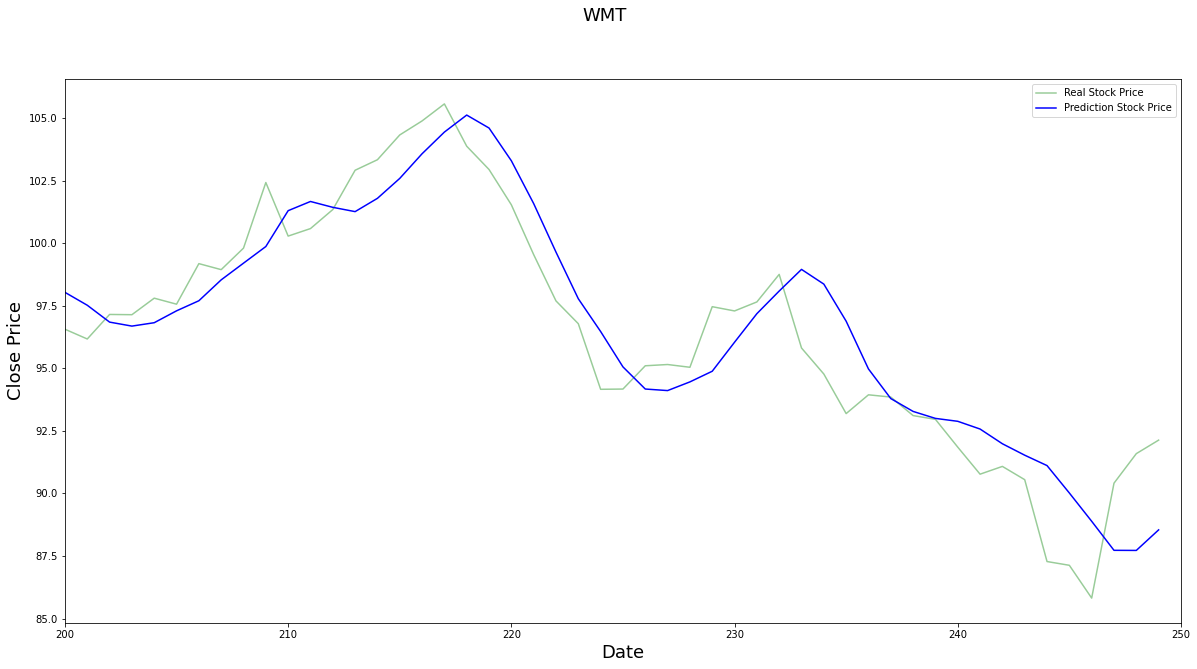

We will not choose this stock.


In [42]:
for i in range (len(stocks)):
    close_price = stocks[i]
    train_apple = close_price[:len(close_price)-50]
    test_apple = close_price[len(close_price)-50:]
    min_apple = np.min(test_apple)
    max_apple = np.max(test_apple)
    scale = MinMaxScaler()
    train_apple = train_apple.reshape(-1,1)
    test_apple = test_apple.reshape(-1,1)
    close_price = close_price.reshape(-1,1)
    #print(train_apple.shape)
    #print(test_apple.shape)
    #print(min_apple)
    #print(max_apple)
    s_window = 50 # 60, 80 , 100, 150
    nclose_price = np.zeros((len(close_price),1))
    
    #Normalization
    for j in range(0,len(close_price),s_window):
        scale.fit(close_price[j:j + s_window,:])
        nclose_price[j:j+s_window,:] = scale.transform(close_price[j:j+s_window,:])
    train_apple = nclose_price[:len(close_price)-50]
    test_apple = nclose_price[len(close_price)-50:]
    date1 = np.arange(len(close_price)-50)+1
    date2 = np.arange(len(close_price)-51,len(close_price)-1)+1
    
    
    #Smoothing
    EMA = 0.0
    lamda = 0.1 #  0.1 or 0.21
    for k in range(len(close_price)-50):
        EMA = lamda*train_apple[k] + (1-lamda)*EMA
        train_apple[k] = EMA
    all_apple = np.concatenate([train_apple,test_apple],axis=0)
    #print(len(train_apple))
    x_train_data,y_train_data=[],[]
    
    #Data Generation
    for l in range(60,len(train_apple)):
        x_train_data.append(train_apple[l-60:l,0])
        y_train_data.append(train_apple[l,0])
    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
    x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
    #print(x_train_data.shape,y_train_data.shape)
    
    #LSTM Model
    lstm_model=Sequential()
    lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))
    inputs_data=all_apple[len(all_apple)-len(test_apple)-60:]
    inputs_data=inputs_data.reshape(-1,1)
    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=1,verbose=2)
    
    #Predict
    X_test=[]
    for m in range(60,inputs_data.shape[0]):
        X_test.append(inputs_data[m-60:m,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price=lstm_model.predict(X_test)
    

    #plot
    
    test_apple_scale = test_apple*(max_apple-min_apple) + min_apple
    final_pred = predicted_closing_price*(max_apple-min_apple) + min_apple
   # gap = (-stock_SMA[i,200:250] + final_pred) / stock_SMA[i,200:250]
    
#     plt.subplot(1,2,1)
    plt.plot(date2,test_apple_scale,label='Real Stock Price',color = 'green',alpha=0.4)
    plt.plot(date2,final_pred,label='Prediction Stock Price',color = 'blue')
#     plt.plot(date2,stock_SMA[i,200:250],label= 'SMA',color='yellow')
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Close Price',fontsize=18)
    plt.xlim(len(close_price)-50,len(close_price))
    plt.legend(loc="upper right")
    
#     plt.subplot(1,2,2)
#     plt.plot(date2, gap, label= 'Gap between prediction and SMA' ,color = 'red')
#     plt.legend(loc="upper right")
#     plt.xlabel('Date',fontsize=18)
#     plt.ylabel('Close Price',fontsize=18)
#     plt.xlim(len(close_price)-50,len(close_price))
    
    plt.suptitle(stock_names[i],fontsize=18)
    plt.show()
    
    # buy and sell 
    n = 0
    amount = 0
    money = 1000
    amount_dia = 0
    temp_min = 100000
    threshold = - 0.05
    maxProfitPercent = (final_pred.max() - final_pred.min())/(max_apple-min_apple)
    
    if (np.argmax(final_pred) > np.argmin(final_pred)) & (maxProfitPercent > 0.10):
        for z in range(len(date2)):
            if (temp_min * 1.10 < final_pred[z]) :
                print('Sell at day: ',z+1)
                print('Total invest days:',n)
                profit = (amount * test_apple_scale[z] - n * money) / (n * money) * 100
                profit_dia = (amount_dia * dia_price[z+200] - n * money) / (n * money) * 100
                if profit > profit_dia :
                    print('Profit made by our model:', profit,'%')
                    print('Profit made by DIA model:', profit_dia,'%')
                    print(stock_names[i],' is chosen')
                break 

            if temp_min > final_pred[z]:
                temp_min = final_pred[z]

            if predicted_closing_price[z] < np.min(predicted_closing_price) + 0.01 and  final_pred[z] >= np.min(final_pred)  :
                print('Buy at day: ',z+1)
                amount += money / test_apple_scale[z]
                amount_dia += money / dia_price[z+200]
                n += 1
    else: 
        print('We will not choose this stock.')

        
#         if gap[z] :
#             print('sell at day',z+1)
#             sell_day = z  
            
#             treshold = np.max(gap) - 0.08
            
#             for k in range(sell_day):
#                 if gap[k] < treshold:
#                     print('buy at day',k+1)
#                     amount += money / test_apple_scale[k]
#                     amount_dia += money / dia_price[k+200]
#                     n += 1
#                     print('amount of the stock: ',amount)  
#                     print('amount of dia:',amount_dia)

#             print('total invest days:',n)

#             profit = (amount * test_apple_scale[z] - n * money)/ (n * money)*100
#             print('Profit made by our model:', profit,'%')
#             profit_dia = (amount_dia * dia_price[z+200] - n * money)/ (n * money)*100
#             print('Profit made by DIA model:', profit_dia,'%')
#             break

In [16]:
final_pred = final_pred.reshape(50)
np.argmax(final_pred)

33